In [1]:
from tdmclient import ClientAsync, aw
client = ClientAsync()
node = await client.wait_for_node()
await node.lock()

Node 64e55146-4396-4fc6-92de-f57708205244

In [2]:
#librairy for kalman
#!pip install filterpy 
#!pip install tqdm
#!pip install pyvisgraph
#!pip install opencv-python
#!pip install opencv-contrib-python --user

In [3]:
#pip install scipy

In [4]:
import numpy as np
import cv2
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
from scipy import ndimage
import math

In [5]:
global speed_right, speed_left, direction,robot_state,new_image,state,index,obst, qp, rp, q_nu, r_nu, dt,frame,shortest_path
speed_left=0
speed_right=0
timer_cam=1
new_image=0
dt=0.1
state=0
direction=0
robot_state=np.array([0,0,0,0],'double') # [x,y,vx,vy]
pos_cam=np.array([0,0],'double')
Ts = 0.1
qp = 0.6 # variance on position state
rp = 0.01 # variance on position measurement
q_nu= 0.1 #variance on speed state
r_nu=0.025 #variance on speed measurement
index=0

In [6]:
class Map:
    def compute_globalmap(self, image, start_id=0, goal_id=1):
        # Generate globalmap : 0:free 1:occupied
        height, width = image.shape[:2]

        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Otsu's thresholding after Gaussian filtering
        blur = cv2.GaussianBlur(gray, (5, 5), 0)
        ret, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # Generate Global map
        # from 0,255 convert to 0(free),1(occupied);change to (x,y) coordinate
        temp_globalmap = np.transpose(np.array(thresh < 255, dtype=int))

        # Detect start and goal by aruco marker
        # Return start and goal position in (x,y) coordinate; if not detected return None
        # start_id: start aruco marker id
        # goal_id=: goal aruco marker id

        # Define aruco marker detector
        arucoDict = cv2.aruco.Dictionary_get(cv2.aruco.DICT_4X4_50)
        arucoParams = cv2.aruco.DetectorParameters_create()

        # Detect aruco marker
        (corners, ids, rejected) = cv2.aruco.detectMarkers(image, arucoDict, parameters=arucoParams)
        start = None
        goal = None
        s_start = 50
        s_goal = 20
        if ids is not None:
            for corner, number in zip(corners, ids):
                (topLeft, topRight, bottomRight, bottomLeft) = corner[0].astype(int)
                centerpoint = ((topLeft[0] + bottomRight[0]) / 2, (topLeft[1] + bottomRight[1]) / 2)
                side_length=math.dist(topLeft, topRight)/2
                self.side_length=side_length
                if number == start_id:
                    start = centerpoint
                    print("start:",start)
                    x_small=int(centerpoint[0]-side_length)-s_start
                    x_large=int(centerpoint[0]+side_length)+s_start
                    y_small =int(centerpoint[1]-side_length)-s_start
                    y_large=int(centerpoint[1]+side_length)+s_start
                    if x_small<0: x_small=0
                    if y_small<0:y_small=0
                    if x_large>=width:x_large=width-1
                    if y_large>=height:y_large=height-1
                    temp_globalmap[x_small:x_large,y_small:y_large] = 0

                elif number == goal_id:
                    goal = centerpoint
                    print("goal:",goal)
                    x_small = int(centerpoint[0] - side_length) - s_goal
                    x_large = int(centerpoint[0] + side_length) + s_goal
                    y_small = int(centerpoint[1] - side_length) - s_goal
                    y_large = int(centerpoint[1] + side_length) + s_goal
                    if x_small < 0: x_small = 0
                    if y_small < 0: y_small = 0
                    if x_large >= width: x_large = width - 1
                    if y_large >= height: y_large = height - 1
                    temp_globalmap[x_small:x_large, y_small:y_large] = 0
                    
                else:
                    pass
        else:
            pass

        globalmap = temp_globalmap.copy()

        if start is None:
            print("NOT detect start point")
        else:
            self.start = start
        if goal is None:
            print("NOT detect goal point")

        else:
            self.goal = goal

        return globalmap

    def avg_globalmap(self,cap,avg_number=10):
        #average first avg_number image to construct global map instead of only use one image
        #in order to get rid of camera unstable problem
        #return self.globalmap
        weight = cap.get(3)
        height=cap.get(4)
        avg_map = np.zeros((int(weight), int(height)))
        for i in range(avg_number):
            ret, img = cap.read()  # returns ret and the frame
            globalmap = self.compute_globalmap(img)
            avg_map = np.add(globalmap, avg_map)
        avg_map = np.divide(avg_map, avg_number)
        avg_map[avg_map >= 0.5] = 1
        avg_map[avg_map < 0.5] = 0
        self.globalmap= avg_map
        return self.globalmap

    def add_margin(self,globalmap,robot_size=70):
       #object inflation, add margin to global map
       #robot_size: robot_size in mm
       #return global map with margin

        # Compute pixel to distance value
        pixel_to_distance = self.compute_pixel_to_distance()

        # obstacle inflation
        # 3x3 structuring element with connectivity 2
        struct = ndimage.generate_binary_structure(2, 2)
        # robot_size:radius of robot(unit:mm)
        margin = int(robot_size / pixel_to_distance) + 1  # margin at least need to be 1, can't be 0
        globalmap = ndimage.binary_dilation(globalmap, structure=struct, iterations=margin).astype(globalmap.dtype)

        self.globalmap = globalmap

        return self.globalmap

    def compute_pixel_to_distance(self):
        # for get pixel_to_ditance value, use function "get_pixel_to_distance"
        # aruco marker:71mmx71mm
        # pixel_to_distance:return real world distance between two neighborhood pixels;unit:mm
        pixel_to_distance = 71 / (self.side_length*2)  # unit:mm
        
        self.pixel_to_distance = pixel_to_distance

        return self.pixel_to_distance

    def get_pixel_to_distance(self):
        return self.pixel_to_distance

    def get_globalmap(self):
        return self.globalmap

    def get_start(self):
        # get the center point of start point
        if self.start is None:
            print("NOT detect start point")
        else:
            pass
        return self.start

    def get_start_distance(self):
        # get the center point of start point in mm
        if self.start is None:
            print("NOT detect start point")
        else:
            pass
        start = np.multiply(self.start , self.pixel_to_distance)
        return start

    def get_goal(self):
        # get the center point of goal point
        if self.goal is None:
            print("NOT detect goal point")
        else:
            pass

        return self.goal

    def get_goal_distance(self):
        # get the center point of start point in mm
        if self.goal is None:
            print("NOT detect start point")
        else:
            pass
        goal = np.multiply(self.goal,self.pixel_to_distance)
        return goal

In [7]:
def compute_vertex(globalmap):

    globalmap = np.uint8(np.dot(np.transpose(globalmap), 255))
    height,width=np.shape(globalmap)

    # apply canny edge detection
    edges = cv2.Canny(globalmap, 60, 160)

    # apply morphology close
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    morph = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

    # get contours
    contours = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # get vertices
    vertices = []
    for i in range(len(contours[0])):
        peri = cv2.arcLength(contours[0][i], True)
        approx = cv2.approxPolyDP(contours[0][i], 0.01 * peri, True)
        vertice = []
        s=10 #margin for boarder of map
        for i in range(len(approx)):
            #push away the vertex at the border of map to make sure robot will not go to border
            if approx[i][0][0]>(0+s):
                if approx[i][0][0]<(width-s):
                    if approx[i][0][1]>(0+s):
                        if approx[i][0][1]<(height-s):pass
                        else:approx[i][0][1]=approx[i][0][1]=10*height
                    else:approx[i][0][1]=approx[i][0][1]=-10*height
                else:approx[i][0][0]=approx[i][0][0]=10*width
            else:approx[i][0][0]=approx[i][0][0]=-10*width
            vertice.append(approx[i][0].tolist())
        vertices.append(np.array(vertice))

    return vertices

In [8]:
def get_robot_position(image,robot_id=0):
    #Detect robot position by aruco marker
    #Return robot position; if not detected return None
    #robot_id: robot aruco marker id

    #Define aruco marker detector
    arucoDict = cv2.aruco.Dictionary_get(cv2.aruco.DICT_4X4_50)
    arucoParams = cv2.aruco.DetectorParameters_create()

    robot_position = None
    angle=None

    #Detect Aruco marker
    (corners, ids, rejected) = cv2.aruco.detectMarkers(image, arucoDict,parameters=arucoParams)
    if ids is not None:
        for corner,number in zip(corners,ids):
            (topLeft, topRight, bottomRight, bottomLeft) = corner[0]
            centerpoint=(int((topLeft[0]+bottomRight[0])/2),int((topLeft[1]+bottomRight[1])/2))
            if number==robot_id:
                robot_position=centerpoint
                angle=angle_calculate(topRight,topLeft)
                break
            else:pass
    else:pass
    return robot_position,angle

def angle_calculate(pt1,pt2):  
    #Get robot angle
    x=pt2[0]-pt1[0] 
    y=pt2[1]-pt1[1]
    angle=np.arctan2(y,x)
    return angle

In [9]:
def kalman(current_state, image):
    global new_image,direction,dt, speed_left, speed_right
    #estimate x-y position with velocity
    #measurements and camera postion measurement
    f = KalmanFilter (dim_x=4, dim_z=4)

    # initial position
    f.x= np.transpose(current_state)
    print(np.dot(f.F,f.x))
    
    #state transition matrix
   
    f.F = np.array([[1, 0, dt, 0],
              [0, 1, 0, dt], 
              [0, 0, 1, 0],
              [0, 0, 0, 1]])

    #measurement function H
    f.H = np.array([[1, 0, 0, 0],
                [0, 1, 0, 0],
                [0, 0, 1, 0],
                [0, 0, 0, 1]])

    #covariance matrix P
    f.P = np.array([[qp, 0, 0, 0], 
              [0, qp, 0, 0], 
              [0, 0, q_nu, 0], 
              [0, 0, 0, q_nu]])

    #measurement noise R (scalar)
    f.R = np.array([[rp, 0, 0, 0],
                [0, rp, 0, 0],
                [0, 0, r_nu, 0],
                [0, 0, 0, r_nu]])

    #process noise Q
    f.Q = Q_discrete_white_noise(dim=4, dt=0.1, var=0.13)
    
    
    #Get position measurement from camera
    pos_cam_temp,direction_temp=get_robot_position(image)
    
    #Get speed measurement from motors and convert them in x-y coordinates
    speed_left=node["motor.left.speed"]
    speed_right=node["motor.right.speed"]
    vx=((speed_left+speed_right)/2)*np.cos(direction)
    vy=((speed_left+speed_right)/2)*np.sin(direction)
    motor_speed=np.array([vx,vy])
    
    
    #if image is up to date, take camera and motor values
    if new_image&(direction_temp!=None): 
        pos_cam=pos_cam_temp
        direction=direction_temp
        z = np.transpose(np.array([pos_cam[0],pos_cam[1], motor_speed[0],motor_speed[1]]))
        
        
    #if camera is hidden, only take motor values
    else:
        z = np.array([current_state[0], current_state[1], motor_speed[0],motor_speed[1]])
        direction=direction+(speed_left-speed_right)*dt/(2*94)
        
    
    f.predict()
    f.update(z)
    
    
    return f.x

In [10]:
#global path

def global_path(start_pos, goal_pos, global_map):

    # Libraries 
    
    import pyvisgraph as vg
    import numpy as np
    import matplotlib.pyplot as plt
    
    # Start and goal acquisition

    start = np.array(start_pos)
    goal = np.array(goal_pos)

    # Reformat in a format accepted by the library (vg.Point)
    
    start_point = vg.Point(start[0], start[1])
    goal_point = vg.Point(goal[0], goal[1])
    
    # Obstacles' vertices acquisition and reformat

    vertices = np.array(global_map)
    vertices = np.asarray(vertices)

    # Create the obstacles from the vertices & add first vertex at the array's end to close them

    max_vertices = 0

    for i in range(len(vertices)):
        if(len(vertices[i])>max_vertices):
            max_vertices = len(vertices[i])

    polygons = [[0 for i in range(max_vertices+1)] for j in range(len(vertices))]

    for i in range(len(vertices)):
        for j in range(len(vertices[i])):
            polygons[i][j] = vg.Point(vertices[i][j][0],vertices[i][j][1])
        polygons[i][(len(vertices[i])):(max_vertices+1)] = [polygons[i][0] for k in range(len(vertices[i]),max_vertices+1)]
    
    # Build visibility graph
    
    graph = vg.VisGraph()
    graph.build(polygons)

    # Compute shortest path
    
    shortest_path = graph.shortest_path(start_point,goal_point)

    # Plot map + shortest path
    
    shortest_path_x = np.empty(len(shortest_path))
    shortest_path_y = np.empty(len(shortest_path))
    
    shortest = [[0 for i in range(2)] for j in range(len(shortest_path))]

    for i in range(len(shortest_path)):
        shortest_path_x[i] = shortest_path[i].x
        shortest_path_y[i] = shortest_path[i].y
        shortest[i][0] = shortest_path[i].x
        shortest[i][1] = shortest_path[i].y
        
    plt.close() # Close previous plots that could be open
    
    fig, ax = plt.subplots(1,1)
    
    for i in range(len(vertices)):
        polygon_plot = Polygon(vertices[i])
        ax.add_patch(polygon_plot)
   
    plt.plot(shortest_path_x,shortest_path_y)
    plt.ylim((0,640))
    plt.xlim((0,480))
    plt.show()
    
    return shortest
    
    

    


In [11]:
def global_nav(path):
    global state,index,direction,speed_left,speed_right
    
    
    #constantes
    v_max=400#mm/s
    #v_min=20
    Diameter=94#mm
    goal_margin=20#mm
    threshold=0.3
    
    #just to tune by test, names wrong
    Kp=0.8
    #CHECK GOAL
  
    if math.sqrt((robot_state[0]-path[index][0])**2+(robot_state[1]-path[index][1])**2)<goal_margin:
        if index+1>=int(np.size(path)/2):
            print('arrived')
            state=2
            return 0,0
        else:
            index=index+1
            print('index : ',index)
    
    
    
    #print("index",index)
    #MOTORS
    obj_angle=np.arctan2(path[index][1]-robot_state[1],path[index][0]-robot_state[0])
    delta_angle=obj_angle-direction
    while(delta_angle>np.pi):
        delta_angle=obj_angle-np.pi
    while(delta_angle<=-np.pi):
        delta_angle=obj_angle+np.pi
    print( obj_angle)
    if abs(delta_angle)>threshold:
        vitesse=0#-Kd_v*abs(obj_angle-direction[present])+Kp_v*abs(50-vitesse[present])#vitesse[present]
        #if vitesse<0:vitesse=0##v_min
    else:
        vitesse=100#-Ki_v*abs(50-vitesse[present])
    #derror=obj_dir(*position[present,:],*path[goal,:])+obj_dir(*position[present-1,:],*path[goal,:])-direction[present]-direction[present-1]
    speed_left=(Kp*(delta_angle))*Diameter#vitesse[present+1]    #0.2*(speed_l[present]+speed_l[present-1])/2    #-Kd_d*derror
    speed_right=-(Kp*(delta_angle))*Diameter#vitesse[present+1]    #0.2*(speed_r[present]+speed_r[present-1])/2+    #-Kd_d*derror
    #bounded speed for turn
    if speed_right<-v_max:speed_right=-v_max
    if speed_right>v_max:speed_right=v_max
    if speed_left<-v_max:speed_left=-v_max
    if speed_left>v_max:speed_left=v_max
    #bounded speed for turn+speedDC
    delta_speed=abs(speed_left-speed_right)
    if speed_left+vitesse>v_max:#PB si les deux au dessus
        speed_left=v_max
        speed_right=v_max-delta_speed
    elif speed_right+vitesse>v_max:
        speed_left=v_max-delta_speed
        speed_right=v_max
    else:
        speed_left=speed_left+vitesse
        speed_right=speed_right+vitesse
    #direction=direction+(-speed_right+speed_left)*0.1/(2*Diameter)
    return speed_left,speed_right

In [12]:
def navigation(path, mapvertex, goal):
    global index,speed_left,speed_right,direction,state,shortest_path, robot_state
   
    obstThrL = 1000    
    obstThrH = 20     
    coef = 3
    

    #Read the proximity sensor values
    prox = list(node.v.prox.horizontal)
    #Only use four exterior ones
    obst=[prox[0], prox[1], prox[3], prox[4]] 
    #Weighted sum of prox sensor values
    left_obst= (obst[0] + 2*obst[1])//3
    right_obst=(2*obst[2] + obst[3])//3
    
    
    #State switching
    #state 0 global nav, state 1 local obstacle avoidance
    # if at least one prox sensor above treshold, go into obstacle avoidance 
    if state == 0:
        if(any(x > obstThrH for x in obst)):
            state = 1
            
            
    # if all prox sensors under treshold, go back to global nav and recompute path away from obstacle    
    elif state == 1:
        if(all(x < obstThrL for x in obst)):
            state = 0
            shortest_path=global_path([robot_state[0],robot_state[1]], goal, mapvertex)
            index=1
    

    
    #Global navigation
    if  state  == 0:
        
        (speed_left, speed_right)=global_nav(path)
        motor_left_target = speed_left
        motor_right_target = speed_right
       
    
    #Local obstacle avoidance
    elif state == 1:
        
        motor_right_target = 100 - coef * (left_obst // 100)
        motor_left_target = 100 - coef * ( right_obst// 100)
        
    #if goal is met, stop  
    else :
        motor_left_target = 0
        motor_right_target = 0
    
    #set speeds
    v = {
            "motor.left.target": [int(motor_left_target*1.5)],
            "motor.right.target": [int(motor_right_target*1.5)],
    }
    aw(node.set_variables(v))
    
   #update direction
    while(direction>np.pi):
        direction=direction-2*np.pi
    while(direction<=-np.pi):
        direction=direction+2*np.pi
    

In [13]:
from threading import Timer

class RepeatedTimer(object):
    def __init__(self, interval, function, *args, **kwargs):
        self._timer     = None
        self.interval   = interval
        self.function   = function
        self.args       = args
        self.kwargs     = kwargs
        self.is_running = False
        self.start()

    def _run(self):
        self.is_running = False
        self.start()
        self.function(*self.args, **self.kwargs)

    def start(self):
        if not self.is_running:
            self._timer = Timer(self.interval, self._run)
            self._timer.start()
            self.is_running = True

    def stop(self):
        self._timer.cancel()
        self.is_running = False




Capturing Video
goal: (499.5, 153.0)
start: (110.0, 136.5)
goal: (499.5, 153.0)
start: (110.0, 136.5)
start: (110.0, 136.5)
goal: (499.0, 153.0)
goal: (499.0, 153.5)
start: (110.0, 136.5)
goal: (499.5, 153.0)
start: (110.0, 136.5)
start: (110.0, 136.5)
goal: (499.5, 153.0)
goal: (499.5, 153.5)
start: (110.0, 136.5)


C:\Users\Administrateur\AppData\Local\Temp\ipykernel_13928\4250436086.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  vertices = np.array(global_map)


goal: (499.0, 153.5)
start: (110.0, 136.5)
start: (110.0, 136.5)
goal: (499.5, 153.0)
goal: (499.5, 153.0)
start: (110.0, 136.5)


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 200.38it/s]


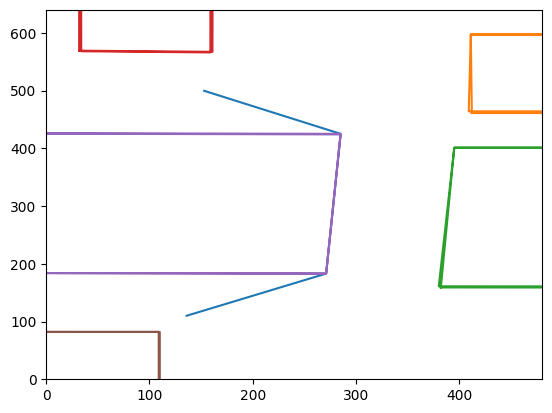

shortest_path : [[110.0, 136.0], [183.0, 271.0], [424.0, 285.0], [425.0, 285.0], [499.5, 153.0]]
[ 110.          136.           41.49891073 -144.54873715]
1.0755328716073025
[110.00446812 135.86517296   9.72186744 -14.65299285]
1.0751609767379608
[110.00275739 135.98211033   2.08231343  -1.54055937]
1.072062502948623
[110.0060326  136.98240023   3.53175424   0.81085831]
1.0657702175566572
[110.00673815 138.96833767   3.837794     0.8227904 ]
1.0649804553496098
[ 1.10978191e+02  1.40968157e+02 -3.24544637e+00 -5.24349903e-03]
1.0675614180241824
[111.9753312  141.98394114  -4.55128513   0.90352488]
1.0670169378868988
[112.97762192 143.96836466  -3.21838367   0.83008476]
1.0669817648129043
[112.97275919 143.97011168  -2.79328732   1.27464436]
1.0669308383584795
[112.96634532 143.97377824  -3.61317944   2.99795818]
1.0846415713180453
[116.92824628 145.97279223  -3.13464549   3.87719541]
1.0878965353313002
[117.98013825 146.98780622  -1.43707895   1.42429647]
1.1004886775835703
[119.9652893

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 150.89it/s]


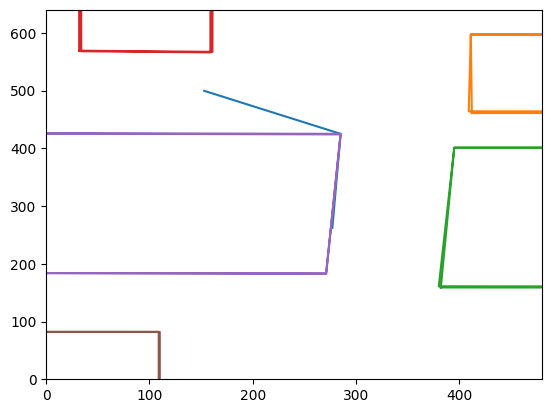

-3.0655184814421372
[262.1904261  277.0359946  109.04061952  30.59926647]
0.03173795303527611
[268.26607508 280.05566375 107.28247848  31.34941348]
0.026206490055434833
[273.11575533 281.04494808 110.91443426  38.68336323]
0.01980492478614373
[275.16261514 282.05190133 111.55314486  39.36907999]
0.019795283201591147
[275.0704299  282.05151185  36.95827756   8.93517155]
0.01342924830390643
[275.04033739 282.99946344  22.42954145   6.69787499]
0.02008716991150096
[276.01335666 282.02696727  16.68989487   4.82651225]
0.020211114856739484
[276.0272872  282.00889922  15.54355887   4.7779542 ]
0.02068886081636557
[280.09071809 282.02225603  90.18534562  30.15376695]
0.014072320661295034
[284.11997669 283.03143351 106.06918827  26.07661031]
0.007167161848318777
[288.15179361 284.02633725 124.95912446  24.87032614]
0.007113715256870045
[289.20990926 284.0411255  129.03483767  22.42208492]
-0.00016448004217414576
[294.14747488 285.02135815 130.12577096  20.31690639]
-0.008163669869578364
[299.1

In [18]:
import matplotlib.pyplot as plt
import time

#start when center button is released
await node.wait_for_variables()
v={
    "node.v.button.center": [0],
}
aw(node.set_variables(v))
while(node.v.button.center!=1):
    v={
        "leds.bottom.right": [100,0,0],
        "leds.bottom.left": [100,0,0],
    }
    aw(node.set_variables(v))
v={
    "leds.bottom.right": [0,100,0],
    "leds.bottom.left": [0,100,0],
}
aw(node.set_variables(v))
await client.sleep(3)
my_map=Map()
state=0
index=1
new_image=0

#Take picture 
print("Capturing Video")
cap = cv2.VideoCapture(1) #Resolution (640,480):camera provided in class
ret, frame = cap.read() 

#Create global map
global_map=my_map.avg_globalmap(cap)
global_map=my_map.add_margin(global_map)
start_pos=my_map.get_start()
goal_pos= my_map.get_goal()

#initialize robot state
robot_start_pos,direction=get_robot_position(frame)
robot_state[0]=robot_start_pos[0]
robot_state[1]=robot_start_pos[1]

#Compute shortest path from global map
vertex= compute_vertex(global_map)
shortest_path= global_path(robot_start_pos, goal_pos, vertex)
print("shortest_path :",shortest_path)


dt=0.1

#Main loop every 0.1 sec
while(state!=2):
    
    time_=time.time()
    
    #Take a new picture
    ret, frame = cap.read()
    new_image=1
    
    #Filter robot state with kalman 
    robot_state=kalman(robot_state, frame)
    
    #Motion
    navigation(shortest_path, vertex, goal_pos)
    
 
    dt=time.time()-time_
    

#If arrived to goal or loop ended, stop 
v = {
        "motor.left.target": [0],
        "motor.right.target": [0],
        "leds.bottom.right": [0,0,100],
        "leds.bottom.left": [0,0,100],
    }
aw(node.set_variables(v))

In [ ]:
v = {
        "motor.left.target": [0],
        "motor.right.target": [0],
    }
aw(node.set_variables(v))